# Importing libraries


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

from scipy.stats import skew, boxcox_normmax, norm
from scipy.special import boxcox1p


Mounted at /content/gdrive


# Import Datasets

In [ ]:
test_path = '/content/gdrive/My Drive/Housing Prices Competition/Data/test.csv'
train_path  = '/content/gdrive/My Drive/Housing Prices Competition/Data/train.csv'
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)



print("train: ", train.shape)
print("test: ", test.shape)
train.head()

train:  (1460, 81)
test:  (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
# Dropping unnecessary Id column.

train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

In [ ]:
# Backing up target variables and dropping them from train data.

y = train['SalePrice'].reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

In [ ]:
# Merging train test features for engineering.

features = pd.concat([train_features, test_features]).reset_index(drop=True)
print(features.shape)

(2919, 79)


# Highly correlated variables. Remove outliers from the highly correlated variables

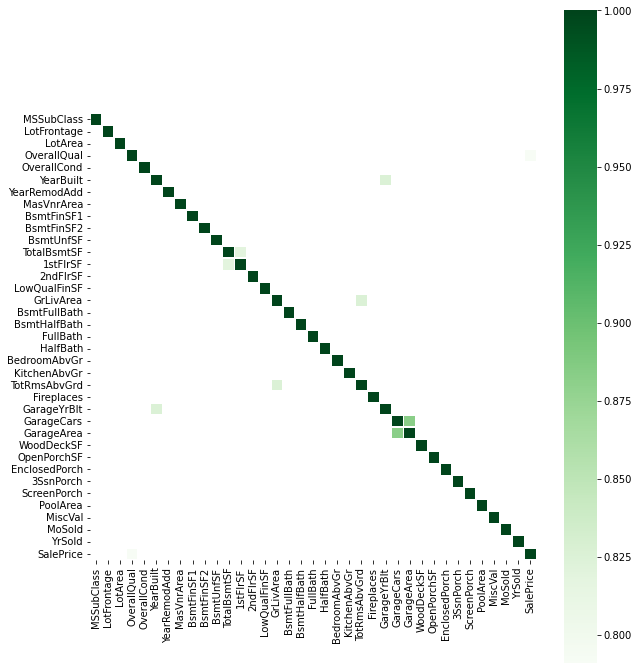

In [ ]:
corrmat=train.corr()
f, ax = plt.subplots(figsize=(10,12))
sns.heatmap(corrmat,mask=corrmat<0.75,linewidth=0.5,cmap="Greens", square=True)

In [ ]:
corrmat=train.corr()
corrmat['SalePrice'].sort_values(ascending=False).head(10)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

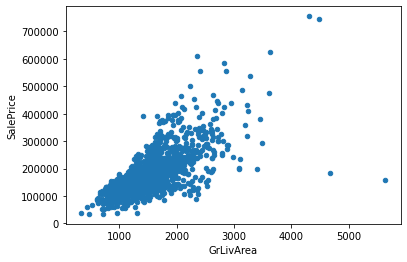

In [ ]:
train.plot.scatter(x='GrLivArea', y='SalePrice')

In [ ]:
train.sort_values(by = 'GrLivArea', ascending = False)[:2]
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<250000)].index)

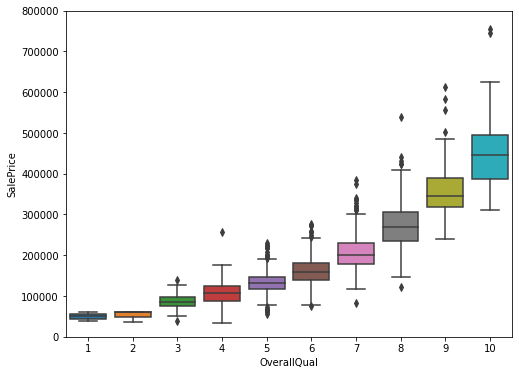

In [ ]:
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x="OverallQual", y="SalePrice", data=train)
fig.axis(ymin=0, ymax=800000);

In [ ]:
train.drop(train[(train.OverallQual==4) & (train.SalePrice>200000)].index,inplace=True)
train.drop(train[(train.OverallQual==8) & (train.SalePrice>500000)].index,inplace=True)
train.drop(train[(train.OverallQual==10) & (train.SalePrice>700000)].index,inplace=True)

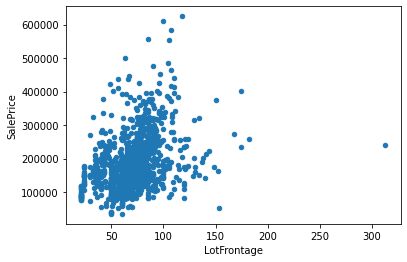

In [ ]:
train.plot.scatter(x='LotFrontage', y='SalePrice')

In [ ]:
train.drop(train[train['LotFrontage'] > 200].index,inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


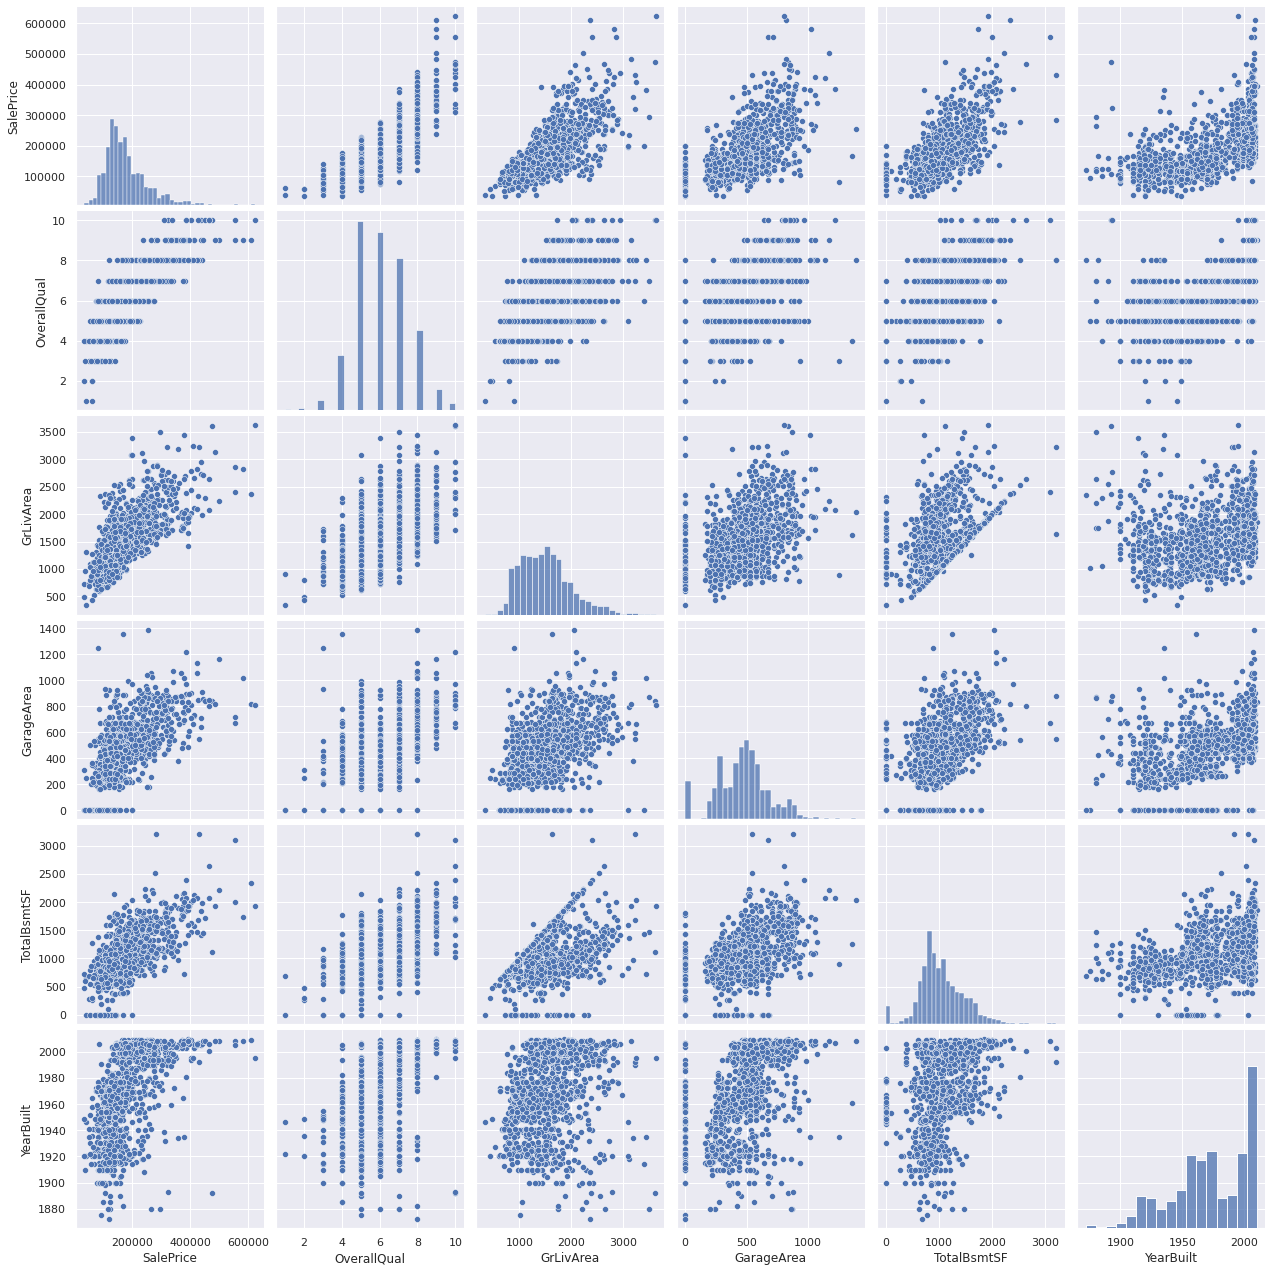

In [ ]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'YearBuilt']
sns.pairplot(train[cols], size = 3)
plt.show()

In [ ]:
train.drop(train[train['TotalBsmtSF'] > 3000].index,inplace=True)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


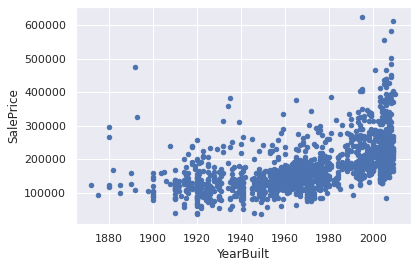

In [ ]:
train.plot.scatter(x='YearBuilt', y='SalePrice')

In [ ]:
train.drop(train[(train.YearBuilt < 1900) & (train.SalePrice > 200000)].index,inplace=True)

In [ ]:
corrmat1=train.corr()
corrmat1['SalePrice'].sort_values(ascending=False).head(10)

SalePrice       1.000000
OverallQual     0.802556
GrLivArea       0.712076
GarageCars      0.650456
TotalBsmtSF     0.643132
GarageArea      0.637602
1stFlrSF        0.617265
YearBuilt       0.564752
FullBath        0.555923
YearRemodAdd    0.524719
Name: SalePrice, dtype: float64

# Features engineering

## Missing Data

In [ ]:
features_na = (features.isnull().sum() / len(features)) * 100
features_na = features_na.drop(features_na[features_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :features_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
FireplaceQu,48.646797
LotFrontage,16.649538
GarageFinish,5.447071
GarageQual,5.447071
GarageCond,5.447071
GarageYrBlt,5.447071


Text(0.5, 1.0, 'Percent missing data by feature')

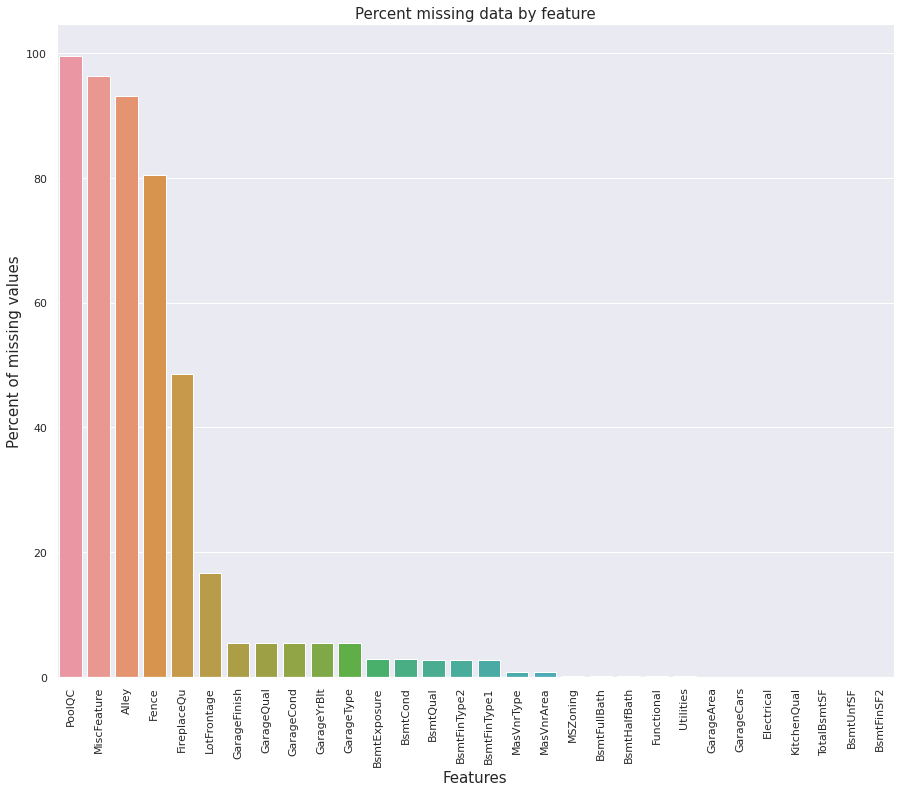

In [ ]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=features_na.index, y=features_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [ ]:
# List of 'NaN' including columns where NaN's mean none.

none_cols = [
    'Alley', 'PoolQC', 'MiscFeature', 'Fence', 'FireplaceQu', 'GarageType',
    'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'
]

# List of 'NaN' including columns where NaN's mean 0.

zero_cols = [
    'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
    'BsmtHalfBath', 'GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea'
]

# List of 'NaN' including columns where NaN's actually missing gonna replaced with mode.

freq_cols = [
    'Electrical', 'Exterior1st', 'Exterior2nd', 'Functional', 'KitchenQual',
    'SaleType', 'Utilities'
]

# Filling the list of columns above with appropriate values:

for col in zero_cols:
    features[col].replace(np.nan, 0, inplace=True)

for col in none_cols:
    features[col].replace(np.nan, 'None', inplace=True)

for col in freq_cols:
    features[col].replace(np.nan, features[col].mode()[0], inplace=True)

In [ ]:
# Filling 'MSZoning' according to MSSubClass.

features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].apply(
    lambda x: x.fillna(x.mode()[0]))

In [ ]:
# Filling 'MSZoning' according to Neighborhood.

features['LotFrontage'] = features.groupby(
    ['Neighborhood'])['LotFrontage'].apply(lambda x: x.fillna(x.median()))

In [ ]:
# Features which numerical on data but should be treated as category:

features['MSSubClass'] = features['MSSubClass'].astype(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

In [ ]:
#Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.
features = features.drop(['Utilities'], axis=1)


In [ ]:
# Transforming rare values(less than 10) into one group.

others = [
    'Condition1', 'Condition2', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
    'Heating', 'Electrical', 'Functional', 'SaleType'
]

for col in others:
    mask = features[col].isin(
        features[col].value_counts()[features[col].value_counts() < 10].index)
    features[col][mask] = 'Other'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


### Check remaining missing values if any 

In [ ]:
features_na = (features.isnull().sum() / len(features)) * 100
features_na = features_na.drop(features_na[features_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :features_na})
missing_data.head()

,Missing Ratio


In [ ]:
features.shape

(2919, 78)

## Categorical Data

In [ ]:
neigh_map = {
    'MeadowV': 1,
    'IDOTRR': 1,
    'BrDale': 1,
    'BrkSide': 2,
    'OldTown': 2,
    'Edwards': 2,
    'Sawyer': 3,
    'Blueste': 3,
    'SWISU': 3,
    'NPkVill': 3,
    'NAmes': 3,
    'Mitchel': 4,
    'SawyerW': 5,
    'NWAmes': 5,
    'Gilbert': 5,
    'Blmngtn': 5,
    'CollgCr': 5,
    'ClearCr': 6,
    'Crawfor': 6,
    'Veenker': 7,
    'Somerst': 7,
    'Timber': 8,
    'StoneBr': 9,
    'NridgHt': 10,
    'NoRidge': 10
}

features['Neighborhood'] = features['Neighborhood'].map(neigh_map).astype(
    'int')
ext_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
features['ExterQual'] = features['ExterQual'].map(ext_map).astype('int')
features['ExterCond'] = features['ExterCond'].map(ext_map).astype('int')
bsm_map = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
features['BsmtQual'] = features['BsmtQual'].map(bsm_map).astype('int')
features['BsmtCond'] = features['BsmtCond'].map(bsm_map).astype('int')
bsmf_map = {
    'None': 0,
    'Unf': 1,
    'LwQ': 2,
    'Rec': 3,
    'BLQ': 4,
    'ALQ': 5,
    'GLQ': 6
}

features['BsmtFinType1'] = features['BsmtFinType1'].map(bsmf_map).astype('int')
features['BsmtFinType2'] = features['BsmtFinType2'].map(bsmf_map).astype('int')
heat_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
features['HeatingQC'] = features['HeatingQC'].map(heat_map).astype('int')
features['KitchenQual'] = features['KitchenQual'].map(heat_map).astype('int')
features['FireplaceQu'] = features['FireplaceQu'].map(bsm_map).astype('int')
features['GarageCond'] = features['GarageCond'].map(bsm_map).astype('int')
features['GarageQual'] = features['GarageQual'].map(bsm_map).astype('int')

### Creating new features

In [ ]:
# Creating new features  based on previous observations. There might be some highly correlated features now. You cab drop them if you want to...

features['TotalSF'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                       features['1stFlrSF'] + features['2ndFlrSF'])
features['TotalBathrooms'] = (features['FullBath'] +
                              (0.5 * features['HalfBath']) +
                              features['BsmtFullBath'] +
                              (0.5 * features['BsmtHalfBath']))

features['TotalPorchSF'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                            features['EnclosedPorch'] +
                            features['ScreenPorch'] + features['WoodDeckSF'])

features['YearBlRm'] = (features['YearBuilt'] + features['YearRemodAdd'])

# Merging quality and conditions.

features['TotalExtQual'] = (features['ExterQual'] + features['ExterCond'])
features['TotalBsmQual'] = (features['BsmtQual'] + features['BsmtCond'] +
                            features['BsmtFinType1'] +
                            features['BsmtFinType2'])
features['TotalGrgQual'] = (features['GarageQual'] + features['GarageCond'])
features['TotalQual'] = features['OverallQual'] + features[
    'TotalExtQual'] + features['TotalBsmQual'] + features[
        'TotalGrgQual'] + features['KitchenQual'] + features['HeatingQC']

# Creating new features by using new quality indicators.

features['QualGr'] = features['TotalQual'] * features['GrLivArea']
features['QualBsm'] = features['TotalBsmQual'] * (features['BsmtFinSF1'] +
                                                  features['BsmtFinSF2'])
features['QualPorch'] = features['TotalExtQual'] * features['TotalPorchSF']
features['QualExt'] = features['TotalExtQual'] * features['MasVnrArea']
features['QualGrg'] = features['TotalGrgQual'] * features['GarageArea']
features['QlLivArea'] = (features['GrLivArea'] -
                         features['LowQualFinSF']) * (features['TotalQual'])
features['QualSFNg'] = features['QualGr'] * features['Neighborhood']



### Finding skewness of the numerical features. Applying boxcox transformation to fix skewness.



In [ ]:
skewed = [ 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
    'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'GrLivArea',
    'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
    'ScreenPorch', 'PoolArea', 'MiscVal'
]

In [ ]:
skew_features = np.abs(features[skewed].apply(lambda x: skew(x)).sort_values(
    ascending=False))
high_skew = skew_features[skew_features > 0.3]
skew_index = high_skew.index
for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3538: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


In [ ]:
# Features to drop:

to_drop = [
    'YrSold',
    'MoSold',
    'ExterQual',
    'BsmtQual',
    'GarageQual',
    'KitchenQual',
    'HeatingQC',
]

# Dropping features.

features.drop(columns=to_drop, inplace=True)

### Getting dummy variables for categorical data.

In [ ]:
features = pd.get_dummies(data=features)

## Check data

In [ ]:
print(f'Number of missing values: {features.isna().sum().sum()}')

Number of missing values: 0


In [ ]:
features.shape

(2919, 224)

In [ ]:
features.sample(5)

,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterCond,BsmtCond,...,SaleType_ConLD,SaleType_New,SaleType_Other,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
2629,63.0,14.225743,9,9,5,2006,2006,18.814103,3,4,...,0,1,0,0,0,0,0,0,0,1
1021,64.0,13.148427,5,7,5,2006,2006,12.928918,3,3,...,0,1,0,0,0,0,0,0,0,1
1086,21.0,10.540155,1,4,5,1973,1973,0.000000,3,3,...,0,0,0,1,0,0,0,0,1,0
1607,88.0,14.154746,8,7,5,2008,2008,10.944968,3,3,...,0,0,0,1,0,0,0,0,1,0
999,64.0,12.959712,5,7,5,2006,2006,6.794089,3,3,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
features.describe()

,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterCond,BsmtCond,...,SaleType_ConLD,SaleType_New,SaleType_Other,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,...,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,69.542994,13.558561,4.464543,6.089072,5.564577,1971.312778,1984.264474,8.050214,3.085646,2.918465,...,0.008907,0.081877,0.009935,0.865365,0.065091,0.004111,0.008222,0.015759,0.822885,0.083933
std,21.703256,1.070188,2.467477,1.409947,1.113131,30.291442,20.894344,10.974237,0.372361,0.574950,...,0.093973,0.274225,0.099195,0.341392,0.246728,0.063996,0.090317,0.124562,0.381832,0.277335
min,21.000000,9.773729,1.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,60.000000,13.168580,3.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,3.000000,3.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,70.000000,13.661722,4.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,3.000000,3.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,80.000000,14.094651,5.000000,7.000000,6.000000,2001.000000,2004.000000,17.798205,3.000000,3.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,313.000000,21.234921,10.000000,10.000000,9.000000,2010.000000,2010.000000,49.871827,5.000000,4.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Separating train and test set.

train = features.iloc[:len(y), :]
test = features.iloc[len(train):, :]

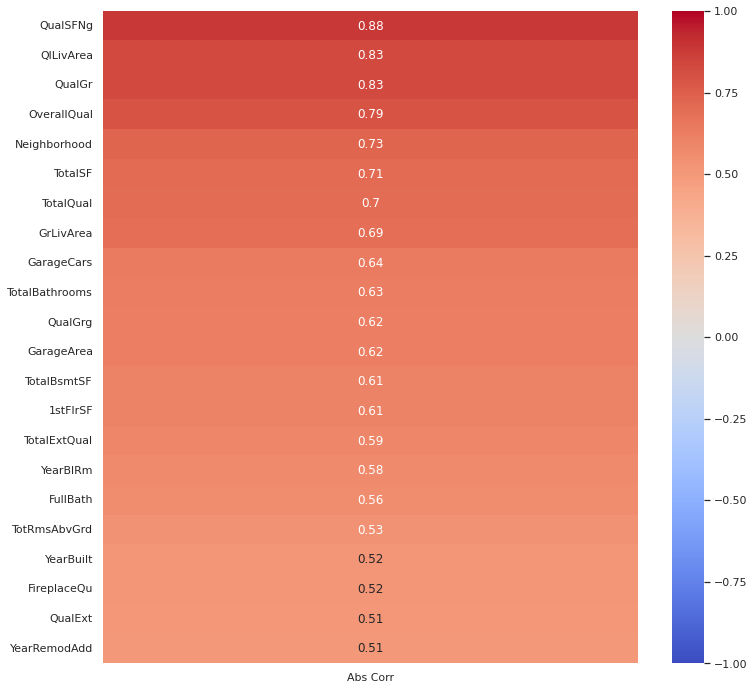

In [ ]:
correlations = train.join(y).corrwith(train.join(y)['SalePrice']).iloc[:-1].to_frame()
correlations['Abs Corr'] = correlations[0].abs()
sorted_correlations = correlations.sort_values('Abs Corr', ascending=False)['Abs Corr']
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(sorted_correlations.to_frame()[sorted_correlations>=.5], cmap='coolwarm', annot=True, vmin=-1, vmax=1, ax=ax);

# Modeling

In [ ]:
# Setting model data.

X = train
X_test = test
y = np.log1p(y)

In [ ]:
# Loading neccesary packages for modelling.

from sklearn.model_selection import cross_val_score, KFold, cross_validate
from sklearn.linear_model import ElasticNetCV, LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error


In [ ]:
# Setting kfold for future use.

kf = KFold(10)

In [ ]:
# Some parameters for lasso and elasticnet.

alphas2 = [
    5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008
]
e_alphas = [
    0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007
]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [ ]:
lasso = LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kf)

In [ ]:
elasticnet = ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kf, random_state=42, l1_ratio=e_l1ratio)

In [ ]:
gbr = GradientBoostingRegressor(n_estimators=2900,
                                learning_rate=0.0161,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=17,
                                loss='huber',
                                random_state=42)

In [ ]:
lightgbm = LGBMRegressor(objective='regression',
                         n_estimators=3500,
                         num_leaves=5,
                         learning_rate=0.00721,
                         max_bin=163,
                         bagging_fraction=0.35711,
                         n_jobs=-1,
                         bagging_seed=42,
                         feature_fraction_seed=42,
                         bagging_freq=7,
                         feature_fraction=0.1294,
                         min_data_in_leaf=8)

In [ ]:
xgboost = XGBRegressor(
    learning_rate=0.0139,
    n_estimators=4500,
    max_depth=4,
    min_child_weight=0,
    subsample=0.7968,
    colsample_bytree=0.4064,
    nthread=-1,
    scale_pos_weight=2,
    seed=42,)

## Cross Validation

In [ ]:
def model_check(X, y, estimators, cv):
    
    ### A function for testing multiple estimators.
    
    model_table = pd.DataFrame()

    row_index = 0
    for est, label in zip(estimators, labels):

        MLA_name = label
        model_table.loc[row_index, 'Model Name'] = MLA_name

        cv_results = cross_validate(est,
                                    X,
                                    y,
                                    cv=cv,
                                    scoring='neg_root_mean_squared_error',
                                    return_train_score=True,
                                    n_jobs=-1)

        model_table.loc[row_index, 'Train RMSE'] = -cv_results[
            'train_score'].mean()
        model_table.loc[row_index, 'Test RMSE'] = -cv_results[
            'test_score'].mean()
        model_table.loc[row_index, 'Test Std'] = cv_results['test_score'].std()
        model_table.loc[row_index, 'Time'] = cv_results['fit_time'].mean()

        row_index += 1

    model_table.sort_values(by=['Test RMSE'],
                            ascending=True,
                            inplace=True)

    return model_table

In [ ]:
estimators = [lasso, elasticnet, gbr, xgboost, lightgbm]
labels = ['Lasso', 'Elasticnet', 'GradientBoostingRegressor',
    'XGBRegressor', 'LGBMRegressor']

In [ ]:
raw_models = model_check(X, y, estimators, kf)
display(raw_models.style.background_gradient(cmap='summer_r'))

,Model Name,Train RMSE,Test RMSE,Test Std,Time
3,XGBRegressor,0.012519,0.115941,0.016614,37.285918
2,GradientBoostingRegressor,0.071082,0.118003,0.021065,23.466920
4,LGBMRegressor,0.082175,0.118055,0.016951,1.667562
0,Lasso,0.102746,0.122592,0.017413,267.604164
1,Elasticnet,0.102816,0.122779,0.017650,1095.592732


In [ ]:
# Fitting the models on train data.

elastic_model_full_data = elasticnet.fit(X, y)

lasso_model_full_data = lasso.fit(X, y)

gbr_model_full_data = gbr.fit(X, y)

xgb_model_full_data = xgboost.fit(X, y)

lgb_model_full_data = lightgbm.fit(X, y)

[15:42:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
# Blending models by assigning weights:

def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) +
            (0.1 * lasso_model_full_data.predict(X)) +
            (0.3 * gbr_model_full_data.predict(X)) +
            (0.3 * xgb_model_full_data.predict(X)) +
            (0.2 * lgb_model_full_data.predict(X)))

In [ ]:
submission = pd.read_csv('/kaggle/input/home-data-for-ml-course/test.csv')
submission['SalePrice'] = np.floor(np.expm1(blend_models_predict(X_test)))
submission = submission[['Id', 'SalePrice']]

In [ ]:
# Saving submission file

submission.to_csv('mysubmission.csv', index=False)
print('Save submission')
submission.head()